In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
from glob import glob 
from skimage.io import imread #read images from files
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tensorflow/l

In [2]:
# Output files
MODEL_FILE = "model.h5"
ROC_PLOT_FILE = "roc.png"
MODEL_PLOT_FILE = "model_plot.png"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
os.chdir("/Users/zakariaalsahfi/Documents/Maryvill/SP20/DSCI 419 DEEP LEARNING/DL-FinalProject/data")
base_tile_dir = 'train'

In [3]:
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[1].split(".")[0])
labels = pd.read_csv("train_labels.csv")
df_data = df.merge(labels, on = "id")
df.head(3)

,path,id
0,train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5
1,train/000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598
2,train/00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1


In [4]:
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df_data.head(3)

,path,id,label
0,train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,train/000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,train/00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1,0


In [5]:
#SAMPLE_SIZE = 80000 # load 80k negative examples
SAMPLE_SIZE = 80000 # load 80k negative examples test
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

In [6]:
# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, 
                                    random_state=101, stratify=y)

In [7]:
# Create directories
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
test_path = '../input/test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [8]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,path,label
id,,
4786962fd5cf461319cc758d207fdc13abbe46e4,train/4786962fd5cf461319cc758d207fdc13abbe46e4...,1
7ab309f94f8c2e855bfc62e5a33ca596b442cb8f,train/7ab309f94f8c2e855bfc62e5a33ca596b442cb8f...,0
ccfeac047df49b2750966be0f97b7ddef7e2320f,train/ccfeac047df49b2750966be0f97b7ddef7e2320f...,1
fe5c69158b743f81e9dae66409bef9ec253de3bd,train/fe5c69158b743f81e9dae66409bef9ec253de3bd...,0
a3c70ed491448475b27a1a02d7df3526cb0600ad,train/a3c70ed491448475b27a1a02d7df3526cb0600ad...,1


In [9]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
     # get the label for a certain image
    label = str(df_data.loc[image,'label'])
    src = os.path.join('../data/train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

In [10]:
for image in df_val['id'].values:
    fname = image + '.tif'
    # get the label for a certain image
    label = str(df_data.loc[image,'label']) 
    src = os.path.join('../data/train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

In [11]:
IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(
        rescale= 1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
       )

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [12]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________

In [13]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
#restore_best_weights=True
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_gen, 
                              steps_per_epoch=train_steps, 
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              epochs=13,
                              callbacks=[reducel, earlystopper,
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_acc',
                                                         verbose=1,
                                                         save_best_only=True,
                                                         mode='max')])

Epoch 1/13
4500/4500 [==============================] - 9672s 2s/step - loss: 0.4250 - acc: 0.8131 - val_loss: 0.9266 - val_acc: 0.5434

Epoch 00001: val_acc improved from -inf to 0.54338, saving model to model.h5
Epoch 2/13
4500/4500 [==============================] - 6884s 2s/step - loss: 0.3568 - acc: 0.8490 - val_loss: 0.3428 - val_acc: 0.8502

Epoch 00002: val_acc improved from 0.54338 to 0.85019, saving model to model.h5
Epoch 3/13
4500/4500 [==============================] - 7810s 2s/step - loss: 0.3125 - acc: 0.8724 - val_loss: 0.3575 - val_acc: 0.8416

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00003: val_acc did not improve from 0.85019
Epoch 4/13
4500/4500 [==============================] - 12270s 3s/step - loss: 0.2607 - acc: 0.8963 - val_loss: 0.2490 - val_acc: 0.9004

Epoch 00004: val_acc improved from 0.85019 to 0.90044, saving model to model.h5
Epoch 5/13
4500/4500 [==============================] - 6906s 2s/step - loss: 0.252

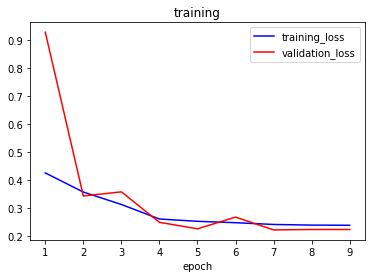

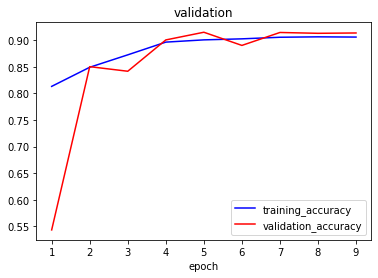

In [14]:
# Training plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.show()
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.show()
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.close()

16000/16000 [==============================] - 212s 13ms/step


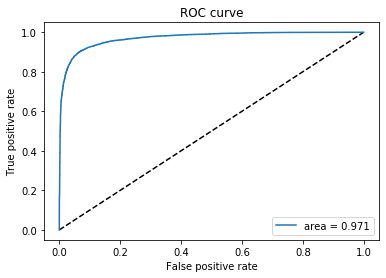

In [15]:
# make a prediction
model.load_weights(MODEL_FILE)
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [16]:
base_test_dir = '../data/test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[1].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

submission.to_csv("submission.csv", index = False, header = True)
pd.read_csv("submission.csv")

Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000


,id,label
0,data,0.000067
1,data,0.000071
2,data,0.000023
3,data,0.002251
4,data,0.000008
...,...,...
57453,data,0.000133
57454,data,0.000191
57455,data,0.000265
57456,data,0.000290
